In [1]:
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
!pwd

/home/aj487/project/purity-monitor


In [3]:
import os
os.chdir('Jupyter/SiPM/')

In [4]:
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
import sys
sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')

In [6]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [7]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor/SiPM.py'>

In [8]:
D0 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211119/', 
                    Selection='*DCR*.h5')
D0.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D0.Files))
for File in D0.Files[:20]:
    D0.ImportDataFromHDF5(File, D0.Ch)

226


In [9]:
def gauss(x,mu=0,sigma=0.1):
    x = x-mu
    return np.exp(-np.square((x-mu)/sigma)/2)/(sigma*np.sqrt(2*np.pi))

In [10]:
time = D0.Ch[0].Time
desire_x = np.arange(-500,500,time[1]-time[0])
desire_y = gauss(desire_x)
resp_x = np.arange(0,1000,time[1]-time[0])
resp_y = D0.func(resp_x, 0, 1, 1.83, 46.93, 0)

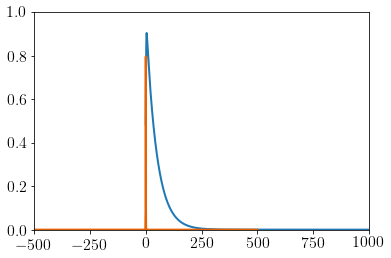

In [11]:
plt.plot(resp_x, resp_y,label='Response')
plt.plot(desire_x, desire_y,label='Desired')

In [12]:
resp_f = np.fft.fft(resp_y)
desire_f = np.fft.fft(desire_y)
filter_f = desire_f/resp_f
filter_y = np.real(np.fft.ifft(filter_f))

In [13]:
import random

true_pe = []
recon_pe = []
min_pe = []
events = 50

for i in range(1000):
    times = [random.randint(0,1000) for x in range(events)]
    ampl = [random.randint(1,2) for x in range(events)]

    f_sing = [D0.func(resp_x, 0, ampl[i]*30, 1.83, 46.93, times[i]) for i in range(len(times))]
    f_sum = np.sum(f_sing, axis=0)
    deconv_y = np.convolve(f_sum,filter_y,'same')
    
    peaks,pdict = find_peaks(deconv_y, height=5, distance=1)
    
    min_pe = np.min(pdict['peak_heights'])
    true_pe.append(np.sum(ampl))
    recon_pe.append(np.round(np.sum(pdict['peak_heights'])))

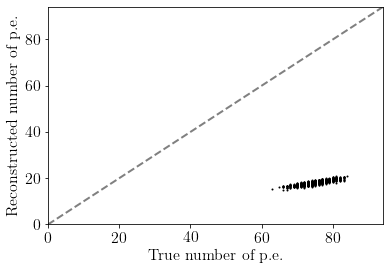

In [14]:
plt.figure()
plt.xlim(0,np.max(true_pe)+10)
plt.ylim(0,np.max(true_pe)+10)
plt.scatter(true_pe, np.array(recon_pe)/30.0, color='k', s=1)
plt.plot([0,1000], [0,1000], ls='--', color='grey')
plt.xlabel('True number of p.e.')
plt.ylabel('Reconstructed number of p.e.')
plt.show()

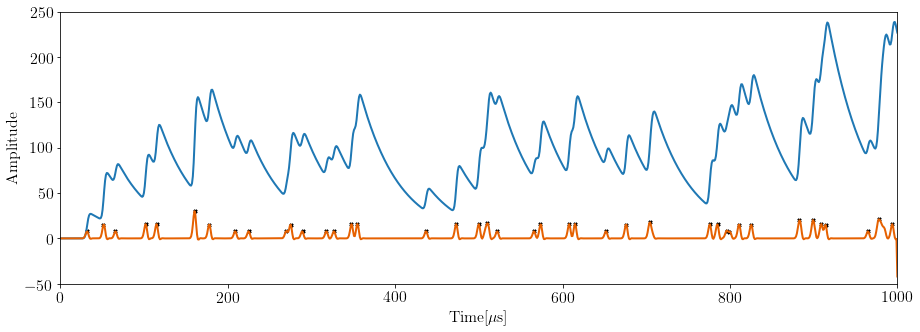

In [15]:
plt.figure(figsize=(15,5))
plt.xlabel('Time[$\mu$s]')
plt.ylabel('Amplitude')
# plt.ylim(-15,100)
plt.plot(resp_x, f_sum,label='Response')
plt.plot(resp_x, deconv_y,label='Deconvolved')
plt.scatter(resp_x[peaks], pdict['peak_heights'], marker='x', color='k', s=10)
plt.savefig('deconvolution.pdf')
plt.show()

7.723193756952155


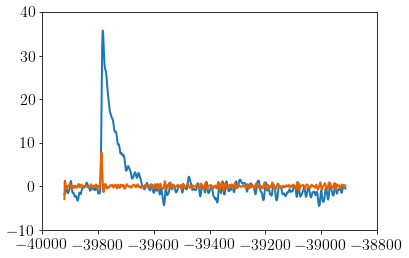

8.087763884635343


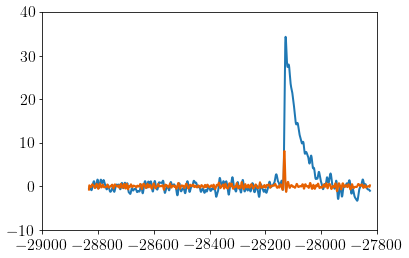

15.988659317220955


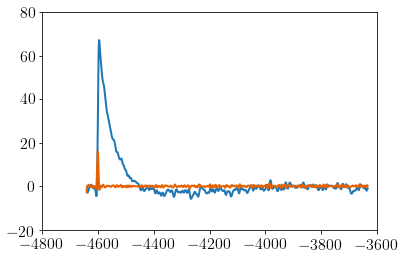

8.912212439430563


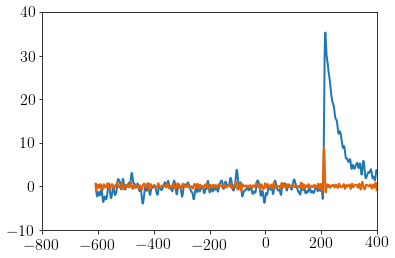

8.196942116809854


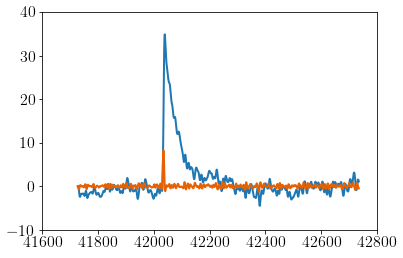

In [16]:
filt = D0.get_filtered_waveform(D0.Ch[0].Time, D0.Ch[0].Amp[10], 
                                lowfreq=100, highfreq=100000, type='band', order=3)
for j in range(100):
    if np.max(filt[1000*j:1000*(j+1)])>20:
        deconv = np.convolve(filt[1000*j:1000*(j+1)],filter_y,'same')
        print(np.max(deconv))
        plt.figure()
        plt.plot(time[1000*j:1000*(j+1)], filt[1000*j:1000*(j+1)],label='Response')
        plt.plot(time[1000*j:1000*(j+1)], deconv,label='Deconvolved')
        plt.show()

In [17]:
start = D0.Ch[0].Time[0]
length = D0.Ch[0].Time[-1] - D0.Ch[0].Time[0]
window = 1000
count = int(length/window)
print(start, length,window, count)

-50000.327999999994 100000.65599999999 1000 100


In [18]:
maxval = []
maxtime = []
for i,Amp in enumerate(D0.Ch[0].Amp):
    filt = D0.get_filtered_waveform(D0.Ch[0].Time, Amp, lowfreq=100, highfreq=100000, type='band', order=3)
    for j in range(count-1):
        if np.max(filt[1000*j:1000*(j+1)])>20:
            deconv = np.convolve(filt[1000*j:1000*(j+1)],filter_y,'same')        
            peaks,pdict = find_peaks(deconv, height=20,  distance=10)
            if len(pdict['peak_heights'])>0:
                for i,p in enumerate(pdict['peak_heights']):
                    maxval.append(p)
                    maxtime.append(D0.Ch[0].Time[1000*j:1000*(j+1)][peaks[i]])

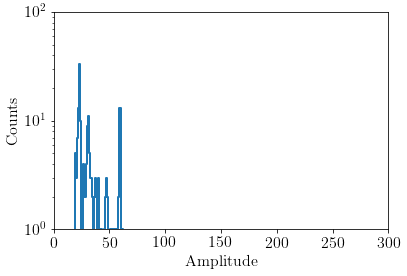

In [20]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

h,hx = np.histogram(maxval, bins=np.arange(0,300,1))

pe = np.median(maxval)
pe_fit = []

plt.figure()
# for i in range(1,7):
#     cut = np.where((hx[:-1]>pe*i-5-1.5*i) & (hx[:-1]<pe*i+4))
    
#     popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
#                           p0=[np.max(h[cut]), pe*i,10])
#     pe_fit.append(popt)
#     plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)    

plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2)
plt.savefig('deconvolution_hist_pe.pdf')
plt.show()

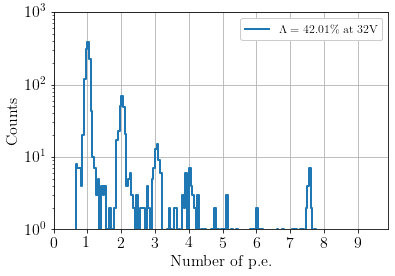

In [ ]:
gain = np.diff(pe_fit[:,1])
gain = np.insert(gain,0,pe_fit[0,1])
maxval_calib = np.array(maxval)/np.mean(gain)
ca = (np.mean(maxval_calib[maxval_calib<7]) - 1)*100

h,hx = np.histogram(maxval_calib, bins=np.arange(0,10,0.05))

plt.figure()
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2, where='post', label='$\Lambda={:.2f}$\% at 32V'.format(ca))
plt.legend(loc='upper right')
plt.savefig('deconvolution_hist_pe.pdf')
plt.show()

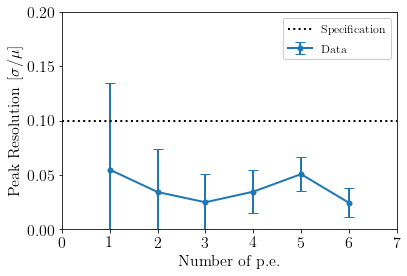

In [ ]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
plt.show()

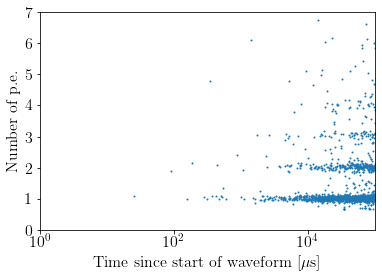

In [ ]:
plt.figure()
plt.xlim(1,1e5)
plt.ylim(0,7)
plt.xscale('log')
plt.yticks(np.arange(0,8,1))
plt.xlabel('Time since start of waveform [$\mu$s]')
plt.ylabel('Number of p.e.')
plt.scatter(np.array(maxtime)+50000, maxval/np.mean(gain), s=1)
plt.show()